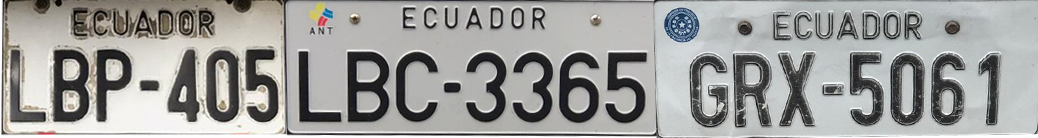

In [1]:
#Librerías

import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
%matplotlib inline 
import matplotlib.image as mpimg
##Presentación 
from IPython.display import Image
Image(filename='placas.png')


In [2]:
#Libreria Opencv library
try:
    import cv2
except ImportError:
    print ("You must have OpenCV installed")
    exit(1)

#check the OpenCV version
try:
    v=cv2.__version__
    assert (tuple(map(int,v.split(".")))>(2,4,3))
except (AssertionError, ValueError):
    print ("Install newer version of OpenCV than 2.4.3, i.e from 2.4.4")
    exit(1)

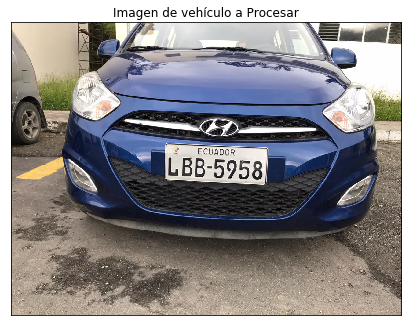

In [3]:
#Se utiliza la siguiente función para leer una imagen a través de OpenCV y mostrarla mediante un plot.
#Sub-proceso 
def mostrar(imagen, ucmap):
    #Hay una diferencia en el ordenamiento de píxeles en OpenCV y Matplotlib.
    #OpenCV sigue el orden BGR, mientras que matplotlib sigue el orden RGB.
    if len(imagen.shape)==3 :
        b,g,r = cv2.split(imagen)       # obtener b,g,r
        imagen = cv2.merge([r,g,b])     # cambiar a r,g,b
    imgplot=plt.imshow(imagen, ucmap)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

plt.rcParams['figure.figsize'] = 7, 7 

# Funcion Principal
plt.title('Imagen de vehículo a Procesar')
imagen_carro="cars\car0.jpeg"
ejemplocarro=cv2.imread(imagen_carro)
#mostrar(ejemplocarro,None)
#imgplot = plt.imshow(ejemplocarro)
mostrar(ejemplocarro, None)

Text(0.5, 1.0, 'Imagen sin Ruido')

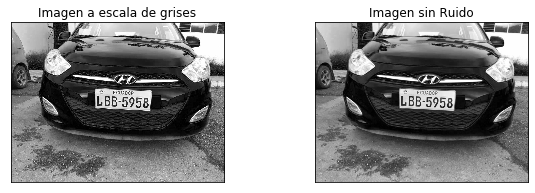

In [4]:
    #Extraccion de capas de la imagen RGB
rgb1=np.matrix(ejemplocarro[:,:,0]) #Azul
rgb2=np.matrix(ejemplocarro[:,:,1])  #Verde
rgb3=np.matrix(ejemplocarro[:,:,2])  #Rojo
    #Diferencia en valor absoluto entre las capas verde y azul
w=cv2.absdiff(rgb2,rgb1)
I=cv2.absdiff(w,rgb3)

plt.figure(figsize=(10,10))
#showfig(gray_ejemplocarro, plt.get_cmap('gray'))
plt.subplot(3,2,1)
mostrar(I, plt.get_cmap('gray'))
plt.title('Imagen a escala de grises')
#desencfoque de imagen
desenfoque=cv2.GaussianBlur(I,(5,5),0)
#desenfoque=cv2.blur(gray_ejemplocarro,(5,5))
plt.subplot(3,2,2)
mostrar(desenfoque, plt.get_cmap('gray'))
plt.title('Imagen sin Ruido')


Text(0.5, 1.0, 'Transformaciones morfologicas')

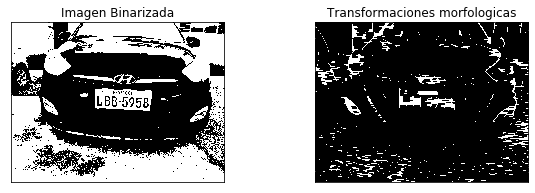

In [5]:
plt.figure(figsize=(10,10))

#Binarizacion de la imagen 
II = I
[fil,col]=II.shape
for j in range(0,fil):
    for jj in range(0,col): #Pixel menor que 80 se hace 0(elimina manchas)
        if II[j,jj]<100:
            II[j,jj]=0
for j in range(0,fil):
    for jj in range(0,col): #Pixel mayor que 0 se hace 1(se resalta la imaen)
        if II[j,jj]>0:
            II[j,jj]=1

plt.subplot(3,2,1)
mostrar(II*255, plt.get_cmap('gray'))
plt.title('Imagen Binarizada')

# Se encuentra el gradiente sobel usa el tamaño del núcleo para ser 3
# El gradiente Sobel es utilizado en procesamiento de imágenes, especialmente en algoritmos de detección de bordes
sobel=cv2.Sobel(desenfoque, cv2.CV_8U, 1, 0, ksize=3)
#Método del valor umbral
#Los métodos del valor umbral son un grupo de algoritmos cuya finalidad es segmentar 
#gráficos rasterizados, es decir, separar los objetos de una imagen que nos interesen del resto.

_,th2=cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
mf=cv2.getStructuringElement(cv2.MORPH_RECT,(23,2))
#Cierre morfologico

cierre=cv2.morphologyEx(th2, cv2.MORPH_CLOSE, mf)

plt.subplot(3,2,2)
mostrar(cierre, plt.get_cmap('gray'))
plt.title('Transformaciones morfologicas')



122 338


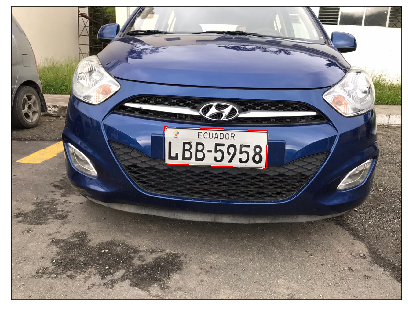

In [6]:
_,contours,_=cv2.findContours(cierre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#imagen_carro="Imagenes_carros\car11.jpeg"
#ejemplocarro=cv2.imread(imagen_carro)
#se valida un contorno mediante la estimación de un área aproximada y la verificación de la relación de aspecto.
def validate(cnt):    
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)  
    salida=False
    ancho=rect[1][0]
    altura=rect[1][1]
    if ((ancho!=0) & (altura!=0)):
        area = (ancho*altura)
        if ((area>30000)&(area<50000)):
          #  print(area)
          #  print(ancho)
          #  print(altura)
            if ((area>35000) &(area<42000)):
                #car0 = 35000    42000   w=122  h=338
                #car7 = 35000    42000   w=280  h=127
                #car11 = 41967           41967.98730468843
                
                salida=True
    return salida

#Permite dibujar contornos validados con rojo.
for cnt in contours:
    if validate(cnt):
        rect=cv2.minAreaRect(cnt)
        box=cv2.boxPoints(rect)
        box=np.int0(box) 
        w=np.int0(rect[1][0])
        h=np.int0(rect[1][1])
        print (w, h)
        
        if (w>h):
            f1,f2,f3,f4 = box
            x1,y_1 = f2
            x_1,y1 = f3
            cv2.drawContours(ejemplocarro, [box], 0, (0,0,255),2)
            placa_corte = ejemplocarro[y1:y1+h,x1:x1+w]
            cv2.imwrite('detectadas\placa_detectada.png',placa_corte)
      
        elif (w<h):
            f1,f2,f3,f4 = box
            x2,y2 = f1
            x1,y_1 = f2
            x_1,y1 = f3
            cv2.drawContours(ejemplocarro, [box], 0, (0,0,255),2)
            placa_corte = ejemplocarro[y1:y2,x1:x2]
            cv2.imwrite('detectadas\placa_detectada.png',placa_corte)

        
mostrar(ejemplocarro, None)


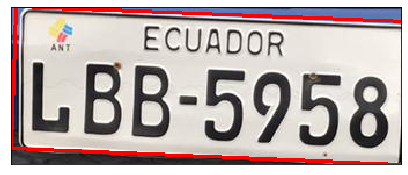

In [7]:
mostrar(placa_corte, None) 


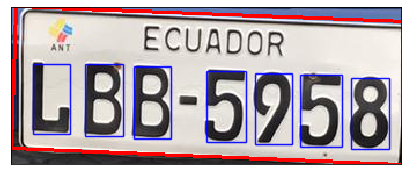

In [8]:
def verdad(cnt):    
    x,y,w,h = bbox = cv2.boundingRect(cnt)
    salida=False
    area = h*w
    if ((h>w) & (area>900)):
        salida=True
    return salida

MIN_CONTOUR_AREA = 10   
placa_detectada = cv2.imread("detectadas\placa_detectada.png")     
gray_placa = cv2.cvtColor(placa_detectada, cv2.COLOR_BGR2GRAY)   
# (2) threshold-inv and morph-open 
th, threshed = cv2.threshold(gray_placa, 100, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
transformada = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, np.ones((2,2)))
# (3) find and filter contours, then draw on src 
contornos = cv2.findContours(transformada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

nh, nw = placa_detectada.shape[:2]
idx=0
a = 0

for cnt in contornos:
    
    if verdad(cnt):
        x,y,w,h = bbox = cv2.boundingRect(cnt)
        cv2.rectangle(placa_detectada, (x,y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
        roi = cv2.resize((placa_detectada[y:y + h, x:x + w]),(38,66))
        cv2.imwrite(('letras/' +str(idx) + '.png'), roi)
        idx+=1
        a = a+1
        
mostrar(placa_detectada,None)

['1.00', '0.98', '1.00', '0.98', '1.00', '1.00', '1.00']
['L', 'B', 'B', '5', '9', '5', '8']


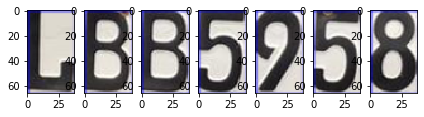

In [10]:
import glob2
images = []
reverso = []
# Change directory where the char are saved, cambia el directorio segun se guarde las imagene 
for img_path in glob2.glob('letras/*.png'):
    images.append(mpimg.imread(img_path))

data = []
for data_path in glob2.glob("alfabeto/*.jpg"):
    data.append({'letra':data_path, 'imagen':mpimg.imread(data_path)})

orden = []
placa = []
orden1= []
probs = []

n=len(images)
#print(n)
if (a<n):
    #print(a)
    images=images[:6] 
#print(images) 
reverso=np.flip(images,0)

for i, image in enumerate(reverso):
    plt.subplot(a / a + 1, a, i + 1)
    plt.imshow(image)
    #plt.subplot(a / a + 1, a, i + 1)
    #plt.imshow(image)  
    for d, im in enumerate(data):
        cor = np.corrcoef(image.flat,im['imagen'].flat)
        result=(sum(cor.flat)/4)
        #print('y='+str(y))
        if (result>=0.9):
            pretty=("%.2f" % result)
            #print(result)  
            #print(im['letra'])
            #plt.subplot(a / a + 1, a, i + 1)
            #plt.imshow(im['imagen'])
            orden1.append(pretty)
            orden.append(im['letra'])
            break

for item in (orden):
    letrita=str(item)
    letrota=letrita.split('\\')[1].split('_')[0]
    placa.append(letrota)

for item1 in (orden1):
    probs.append(item1)
    
    
print(probs)    
print(placa)   